# Intro

Given extensive data on users ratings for movie content, can a model recommend 5 movies based on the user's previous ratings.

In [1]:
#import libraries and tools for EDA and data load
import zipfile
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [2]:
# read .zip
with zipfile.ZipFile("ml-latest-small.zip","r") as zip_ref:
    zip_ref.extractall()

In [3]:
# pull .csv files
txtfiles = []
for file in glob.glob("/Users/ryansims/flatiron-ds-course/mod4_project/ml-latest-small/*.csv"):
    txtfiles.append(file)
txtfiles

['/Users/ryansims/flatiron-ds-course/mod4_project/ml-latest-small/links.csv',
 '/Users/ryansims/flatiron-ds-course/mod4_project/ml-latest-small/tags.csv',
 '/Users/ryansims/flatiron-ds-course/mod4_project/ml-latest-small/ratings.csv',
 '/Users/ryansims/flatiron-ds-course/mod4_project/ml-latest-small/movies.csv']

In [4]:
# load each .csv into a dataframe
links_df = pd.read_csv("ml-latest-small/links.csv")
tags_df = pd.read_csv("ml-latest-small/tags.csv")
ratings_df = pd.read_csv("ml-latest-small/ratings.csv")
movies_df = pd.read_csv("ml-latest-small/movies.csv")

In [5]:
# print each dataframe and look at the info
print(links_df.info())
links_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
imdbId     9742 non-null int64
tmdbId     9734 non-null float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB
None


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [6]:
print(tags_df.info())
tags_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
userId       3683 non-null int64
movieId      3683 non-null int64
tag          3683 non-null object
timestamp    3683 non-null int64
dtypes: int64(3), object(1)
memory usage: 115.2+ KB
None


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [7]:
print(ratings_df.info())
ratings_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
print(movies_df.info())
movies_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
title      9742 non-null object
genres     9742 non-null object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
# drop timestamp columns from ratings and tags

ratings_df.drop(columns=['timestamp'], inplace=True)
tags_df.drop(columns=['timestamp'], inplace=True)


In [81]:
ratings_df.head()
#tags_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


## Initial Notes:

#### The Ratings .csv has the user Id and the ratings they gave for the content.  These factors will go into Collaborative Filtering.
#### The Tags . csv and the Movies .csv has the data necessary for content filtering.
#### The ratings are in integer form as well as the Id's.  The Titles and Genres are all strings.  There aren't any null values that need to be addressed.

# EDA

In [11]:
# use describe to look at the entries and the range of the id numbers for movie ids
movies_df.movieId.describe()

count      9742.000000
mean      42200.353623
std       52160.494854
min           1.000000
25%        3248.250000
50%        7300.000000
75%       76232.000000
max      193609.000000
Name: movieId, dtype: float64

In [12]:
# do the same thing for the ratings_df
ratings_df.movieId.describe()

count    100836.000000
mean      19435.295718
std       35530.987199
min           1.000000
25%        1199.000000
50%        2991.000000
75%        8122.000000
max      193609.000000
Name: movieId, dtype: float64

In [13]:
# inspect the userid with describe
ratings_df.userId.describe()

count    100836.000000
mean        326.127564
std         182.618491
min           1.000000
25%         177.000000
50%         325.000000
75%         477.000000
max         610.000000
Name: userId, dtype: float64

In [14]:
#inspect ratings with describe
ratings_df.rating.describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

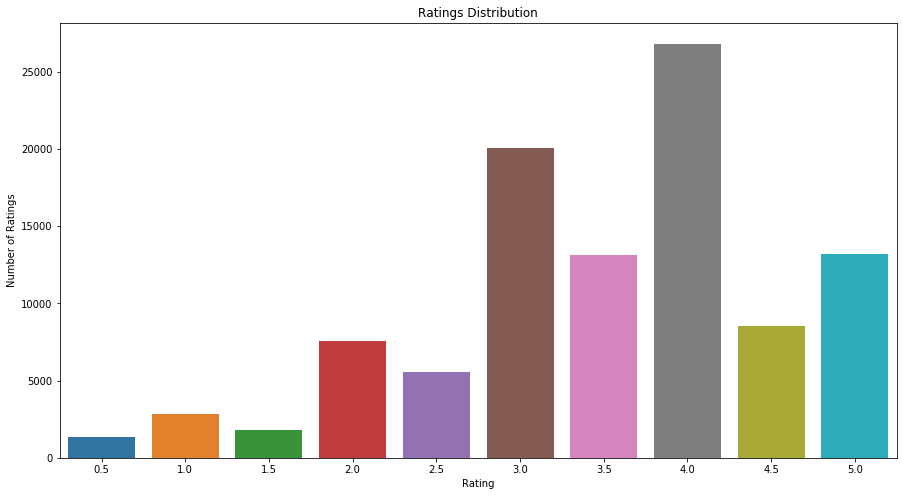

In [15]:
# ratings look to be given in increments of 0.5 
# Look at distribution of ratings
import seaborn as sns
fig = plt.figure(figsize=(15,8))
sns.barplot(x=ratings_df.rating.value_counts().index, y=ratings_df.rating.value_counts().values, )
plt.title('Ratings Distribution')
plt.ylabel('Number of Ratings')
plt.xlabel('Rating')
plt.show()

In [16]:
# combine the movies and ratings to have ratings, userid, and the movie titles and genres together
usr_ratings = pd.merge(movies_df, ratings_df)
usr1 = usr_ratings[usr_ratings.userId == 1]
print(usr1)
usr_ratings.head()
usr_ratings.info()

       movieId                           title  \
0            1                Toy Story (1995)   
325          3         Grumpier Old Men (1995)   
433          6                     Heat (1995)   
2107        47     Seven (a.k.a. Se7en) (1995)   
2379        50      Usual Suspects, The (1995)   
...        ...                             ...   
56816     3744                    Shaft (2000)   
57276     3793                    X-Men (2000)   
57457     3809          What About Bob? (1991)   
59170     4006  Transformers: The Movie (1986)   
65533     5060    M*A*S*H (a.k.a. MASH) (1970)   

                                            genres  userId  rating  
0      Adventure|Animation|Children|Comedy|Fantasy       1     4.0  
325                                 Comedy|Romance       1     4.0  
433                          Action|Crime|Thriller       1     4.0  
2107                              Mystery|Thriller       1     5.0  
2379                        Crime|Mystery|Thriller    

# EDA Notes:

There's 610 users and a total of 100836 ratings.  The most common rating is a 4, and the median rating is 3.5.

# Modeling

In [17]:
#import dataframe classes from surprise

from surprise import Reader, Dataset

rdr = Reader()
data = Dataset.load_from_df(ratings_df, rdr)

dataset = data.build_full_trainset()


In [18]:
print(dataset.n_users)

610


In [19]:
print(dataset.n_items)

9724


In [20]:
print(dataset.n_ratings)

100836


In [21]:
# import surprise libraries
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV

In [22]:
# use gridsearh to find best parameters for SVD
params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
g_s_svd.fit(data)

In [24]:
# print grid search results
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8696286936406595, 'mae': 0.6686138633752965}
{'rmse': {'n_factors': 20, 'reg_all': 0.02}, 'mae': {'n_factors': 20, 'reg_all': 0.02}}


In [25]:
# Cross validate
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

In [27]:
for item in cv_knn_basic.items():
    print(item)

('test_rmse', array([0.97927939, 0.97438708, 0.96632807, 0.97071267, 0.97102755]))
('test_mae', array([0.7579555 , 0.75341747, 0.74444142, 0.74847761, 0.74894087]))
('fit_time', (0.31365513801574707, 0.3121681213378906, 0.3154900074005127, 0.3155663013458252, 0.3182661533355713))
('test_time', (1.0753788948059082, 1.0610120296478271, 1.0693519115447998, 1.0540196895599365, 1.0184199810028076))


In [28]:
# use n_factors =20 and reg = .02 for SVD based on gridsearch and cross validating
svd = SVD(n_factors=20, reg_all=.02)
svd.fit(dataset)

In [66]:
# predict ratings for user 4 and lowest movieId
u_4_m_21 = ratings_df[ratings_df.userId == 4]
u_4_m_21.movieId.describe()

count     216.000000
mean     1982.129630
std      1360.024005
min        21.000000
25%       911.500000
50%      1733.500000
75%      3035.750000
max      4967.000000
Name: movieId, dtype: float64

In [59]:
svd.predict(4,21)

Prediction(uid=4, iid=21, r_ui=None, est=3.3361008780362815, details={'was_impossible': False})

In [67]:
u_4_m_21[u_4_m_21.movieId == 21]

,userId,movieId,rating
300,4,21,3.0


In [79]:
# generate new ratings for new user from randomly selected movieIds
import random
new_usr_id = 611
num_ratings = 20
new_movieIds = movies_df.movieId.sample(num_ratings, random_state=28).values
ratings_list = np.arange(0.5, 5.5, 0.5)

new_usr_ratings = []
for i in range(20):
    new_usr_ratings.append({'userId': new_usr_id, 'movieId': new_movieIds[i], 'rating': random.choice(ratings_list)})
    
new_usr_ratings

[{'userId': 611, 'movieId': 44694, 'rating': 0.5},
 {'userId': 611, 'movieId': 149352, 'rating': 3.0},
 {'userId': 611, 'movieId': 47491, 'rating': 3.5},
 {'userId': 611, 'movieId': 169670, 'rating': 1.5},
 {'userId': 611, 'movieId': 95163, 'rating': 3.5},
 {'userId': 611, 'movieId': 66934, 'rating': 4.0},
 {'userId': 611, 'movieId': 33085, 'rating': 4.0},
 {'userId': 611, 'movieId': 4845, 'rating': 2.0},
 {'userId': 611, 'movieId': 8147, 'rating': 4.0},
 {'userId': 611, 'movieId': 828, 'rating': 4.0},
 {'userId': 611, 'movieId': 8948, 'rating': 3.0},
 {'userId': 611, 'movieId': 84414, 'rating': 2.5},
 {'userId': 611, 'movieId': 91353, 'rating': 5.0},
 {'userId': 611, 'movieId': 26283, 'rating': 1.0},
 {'userId': 611, 'movieId': 2141, 'rating': 1.5},
 {'userId': 611, 'movieId': 186587, 'rating': 4.0},
 {'userId': 611, 'movieId': 4979, 'rating': 3.5},
 {'userId': 611, 'movieId': 157172, 'rating': 3.5},
 {'userId': 611, 'movieId': 71156, 'rating': 1.5},
 {'userId': 611, 'movieId': 4976, 

In [84]:
# load new df into dataset for SVD
new_user_df = ratings_df.append(new_usr_ratings, ignore_index=True)
new_data = Dataset.load_from_df(new_user_df, rdr)

In [85]:
# train SVD
svd_ = SVD(n_factors= 20, reg_all=0.02)
svd_.fit(new_data.build_full_trainset())

In [87]:
# predictions for new user

movie_list = []
for movie in new_user_df.movieId.unique():
    movie_list.append((movie, svd.predict(611,movie)[3]))

In [90]:
#sort movies from highest to lowest rated

ranked = sorted(movie_list, key=lambda x:x[1], reverse=True)

In [91]:
# top 5 movie recommeder function

def movie_rec(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
movie_rec(ranked,movies_df,5)

Recommendation #  1 :  277    Shawshank Redemption, The (1994)
Name: title, dtype: object 

Recommendation #  2 :  602    Dr. Strangelove or: How I Learned to Stop Worr...
Name: title, dtype: object 

Recommendation #  3 :  906    Lawrence of Arabia (1962)
Name: title, dtype: object 

Recommendation #  4 :  686    Rear Window (1954)
Name: title, dtype: object 

Recommendation #  5 :  841    Streetcar Named Desire, A (1951)
Name: title, dtype: object 



# Conclusion

Given the data on users ratings of movies, a model was successfully built that could recommend the top 5 choices to watch next.